In [1]:
import scanpy as sc
import pandas as pd

In [2]:
data_path = "../data/1142243F/"

# adata = sc.read_10x_mtx(data_path + "filtered_count_matrix")

In [3]:
genes = pd.read_csv(data_path + "raw_feature_bc_matrix/" + 'features.tsv.gz', header=None, sep='\t')
genes

,0,1,2
0,ENSG00000243485,MIR1302-2HG,Gene Expression
1,ENSG00000237613,FAM138A,Gene Expression
2,ENSG00000186092,OR4F5,Gene Expression
3,ENSG00000238009,AL627309.1,Gene Expression
4,ENSG00000239945,AL627309.3,Gene Expression
...,...,...,...
36596,ENSG00000277836,AC141272.1,Gene Expression
36597,ENSG00000278633,AC023491.2,Gene Expression
36598,ENSG00000276017,AC007325.1,Gene Expression
36599,ENSG00000278817,AC007325.4,Gene Expression


# The filtered features.tsv doesn't contain the right information (missing spot ID's) - cannot be read

In [25]:
genes

,0
0,AL627309.1
1,AL627309.3
2,AL627309.5
3,AP006222.2
4,AL732372.1
...,...
28397,AC136352.3
28398,AC136616.1
28399,AC007325.1
28400,AC007325.4


In [2]:
"""Reading and Writing
"""
from pathlib import Path, PurePath
from typing import Union, Dict, Optional, Tuple, BinaryIO

import h5py
import json
import numpy as np
import pandas as pd
from matplotlib.image import imread
import anndata
from anndata import (
    AnnData,
    read_csv,
    read_text,
    read_excel,
    read_mtx,
    read_loom,
    read_hdf,
)
from anndata import read as read_h5ad
from scanpy import read_10x_mtx
# from ._settings import settings
# from ._compat import Literal
# from ._utils import Empty, _empty
# from . import logging as logg


In [3]:
def read_visium_mod(
    path: Union[str, Path],
    genome: Optional[str] = None,
    *,
    count_dir: str = "raw_feature_bc_matrix",
    library_id: str = None,
    load_images: Optional[bool] = True,
    source_image_path: Optional[Union[str, Path]] = None,
) -> AnnData:
    """\
    Read 10x-Genomics-formatted visum dataset.
    In addition to reading regular 10x output,
    this looks for the `spatial` folder and loads images,
    coordinates and scale factors.
    Based on the `Space Ranger output docs`_.
    See :func:`~scanpy.pl.spatial` for a compatible plotting function.
    .. _Space Ranger output docs: https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview
    Parameters
    ----------
    path
        Path to directory for visium datafiles.
    genome
        Filter expression to genes within this genome.
    count_file
        Which file in the passed directory to use as the count file. Typically would be one of:
        'filtered_feature_bc_matrix.h5' or 'raw_feature_bc_matrix.h5'.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    source_image_path
        Path to the high-resolution tissue image. Path will be included in
        `.uns["spatial"][library_id]["metadata"]["source_image_path"]`.
    Returns
    -------
    Annotated data matrix, where observations/cells are named by their
    barcode and variables/genes by gene name. Stores the following information:
    :attr:`~anndata.AnnData.X`
        The data matrix is stored
    :attr:`~anndata.AnnData.obs_names`
        Cell names
    :attr:`~anndata.AnnData.var_names`
        Gene names
    :attr:`~anndata.AnnData.var`\\ `['gene_ids']`
        Gene IDs
    :attr:`~anndata.AnnData.var`\\ `['feature_types']`
        Feature types
    :attr:`~anndata.AnnData.uns`\\ `['spatial']`
        Dict of spaceranger output files with 'library_id' as key
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['images']`
        Dict of images (`'hires'` and `'lowres'`)
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['scalefactors']`
        Scale factors for the spots
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['metadata']`
        Files metadata: 'chemistry_description', 'software_version', 'source_image_path'
    :attr:`~anndata.AnnData.obsm`\\ `['spatial']`
        Spatial spot coordinates, usable as `basis` by :func:`~scanpy.pl.embedding`.
    """
    path = Path(path)
    adata = read_10x_mtx(path / count_dir)

    adata.uns["spatial"] = dict()

    from h5py import File

    # with File(path / count_file, mode="r") as f:
    #     attrs = dict(f.attrs)
    # if library_id is None:
    #     library_id = str(attrs.pop("library_ids")[0], "utf-8")

    adata.uns["spatial"][library_id] = dict()

    if load_images:
        files = dict(
            tissue_positions_file=path / 'spatial/tissue_positions_list.csv',
            scalefactors_json_file=path / 'spatial/scalefactors_json.json',
            hires_image=path / 'spatial/tissue_hires_image.png',
            lowres_image=path / 'spatial/tissue_lowres_image.png',
        )

        # check if files exists, continue if images are missing
        for f in files.values():
            if not f.exists():
                if any(x in str(f) for x in ["hires_image", "lowres_image"]):
                    logg.warning(
                        f"You seem to be missing an image file.\n"
                        f"Could not find '{f}'."
                    )
                else:
                    raise OSError(f"Could not find '{f}'")

        adata.uns["spatial"][library_id]['images'] = dict()
        for res in ['hires', 'lowres']:
            try:
                adata.uns["spatial"][library_id]['images'][res] = imread(
                    str(files[f'{res}_image'])
                )
            except Exception:
                raise OSError(f"Could not find '{res}_image'")

        # read json scalefactors
        adata.uns["spatial"][library_id]['scalefactors'] = json.loads(
            files['scalefactors_json_file'].read_bytes()
        )

        # adata.uns["spatial"][library_id]["metadata"] = {
        #     k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
        #     for k in ("chemistry_description", "software_version")
        #     if k in attrs
        # }

        # read coordinates
        positions = pd.read_csv(files['tissue_positions_file'], header=None)
        positions.columns = [
            'barcode',
            'in_tissue',
            'array_row',
            'array_col',
            'pxl_col_in_fullres',
            'pxl_row_in_fullres',
        ]
        positions.index = positions['barcode']

        adata.obs = adata.obs.join(positions, how="left")

        adata.obsm['spatial'] = adata.obs[
            ['pxl_row_in_fullres', 'pxl_col_in_fullres']
        ].to_numpy()
        adata.obs.drop(
            columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'],
            inplace=True,
        )

        # put image path in uns
        if source_image_path is not None:
            # get an absolute path
            source_image_path = str(Path(source_image_path).resolve())
            adata.uns["spatial"][library_id]["metadata"] = {}
            adata.uns["spatial"][library_id]["metadata"]["source_image_path"] = str(
                source_image_path
            )

    return adata


In [4]:
data_path = "../data/Breast_Cancer_10x/block1"

from scanpy import read_visium
adata1 = read_visium(data_path, source_image_path = data_path + "/image.tif")

/scratch/imb/uqjxie6/software/stimage5/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [28]:
 adata.uns['spatial'].keys()

dict_keys(['V1_Breast_Cancer_Block_A_Section_1'])

In [5]:
data_path = "../data/Alex_NatGen/1142243F"
adata2  = read_visium_mod(data_path, library_id = '1142243F', source_image_path = data_path + "/1142243F.tif")

In [9]:
%ls ../data/Alex_NatGen/1142243F

1142243F.tif            metadata.csv            spatial/
filtered_count_matrix/  raw_feature_bc_matrix/


In [13]:
adata2

AnnData object with n_obs × n_vars = 4992 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types'
    uns: 'spatial'
    obsm: 'spatial'

In [14]:
adata2

AnnData object with n_obs × n_vars = 4992 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types'
    uns: 'spatial'
    obsm: 'spatial'

In [18]:
adata2.obs.in_tissue

AAACAACGAATAGTTC-1    0
AAACAAGTATCTCCCA-1    1
AAACAATCTACTAGCA-1    0
AAACACCAATAACTGC-1    1
AAACAGAGCGACTCCT-1    1
                     ..
TTGTTTCACATCCAGG-1    1
TTGTTTCATTAGTCTA-1    1
TTGTTTCCATACAACT-1    1
TTGTTTGTATTACACG-1    1
TTGTTTGTGTAAATTC-1    1
Name: in_tissue, Length: 4992, dtype: int64

In [21]:
adata1.obsm['spatial']

array([[17428, 15937],
       [ 6092, 18054],
       [16351,  7383],
       ...,
       [ 7593, 18294],
       [ 7190, 14730],
       [10484,  5709]])

In [24]:
adata1.uns['spatial']['V1_Breast_Cancer_Block_A_Section_1']

{'images': {'hires': array([[[0.7411765 , 0.7490196 , 0.7372549 ],
          [0.74509805, 0.7529412 , 0.7372549 ],
          [0.7411765 , 0.7490196 , 0.7411765 ],
          ...,
          [0.7490196 , 0.7529412 , 0.7372549 ],
          [0.7411765 , 0.7490196 , 0.7294118 ],
          [0.74509805, 0.75686276, 0.7411765 ]],
  
         [[0.74509805, 0.7490196 , 0.7372549 ],
          [0.7411765 , 0.7529412 , 0.7372549 ],
          [0.74509805, 0.7529412 , 0.7372549 ],
          ...,
          [0.7490196 , 0.7529412 , 0.7372549 ],
          [0.7411765 , 0.7490196 , 0.7372549 ],
          [0.74509805, 0.75686276, 0.7372549 ]],
  
         [[0.74509805, 0.7529412 , 0.7372549 ],
          [0.74509805, 0.7529412 , 0.7372549 ],
          [0.74509805, 0.7529412 , 0.7372549 ],
          ...,
          [0.7490196 , 0.7529412 , 0.7372549 ],
          [0.7490196 , 0.7529412 , 0.7372549 ],
          [0.74509805, 0.7529412 , 0.7411765 ]],
  
         ...,
  
         [[0.7411765 , 0.7490196 , 0.741176

In [26]:
import squidpy as sp

In [28]:
sp.im.ImageContainer.from_adata(adata1)

ImageContainer[shape=(2000, 2000), layers=['hires']]

In [30]:
adata2.uns['spatial']['1142243F']

KeyError: '1142243F'

In [31]:
adata1.obs_names

Index(['AAACAAGTATCTCCCA-1', 'AAACACCAATAACTGC-1', 'AAACAGAGCGACTCCT-1',
       'AAACAGGGTCTATATT-1', 'AAACAGTGTTCCTGGG-1', 'AAACATTTCCCGGATT-1',
       'AAACCCGAACGAAATC-1', 'AAACCGGGTAGGTACC-1', 'AAACCTAAGCAGCCGG-1',
       'AAACCTCATGAAGTTG-1',
       ...
       'TTGTGGTAGGAGGGAT-1', 'TTGTGGTGGTACTAAG-1', 'TTGTGTATGCCACCAA-1',
       'TTGTTAGCAAATTCGA-1', 'TTGTTCAGTGTGCTAC-1', 'TTGTTGTGTGTCAAGA-1',
       'TTGTTTCACATCCAGG-1', 'TTGTTTCATTAGTCTA-1', 'TTGTTTCCATACAACT-1',
       'TTGTTTGTGTAAATTC-1'],
      dtype='object', length=3798)

<Axes: xlabel='array_row', ylabel='array_col'>

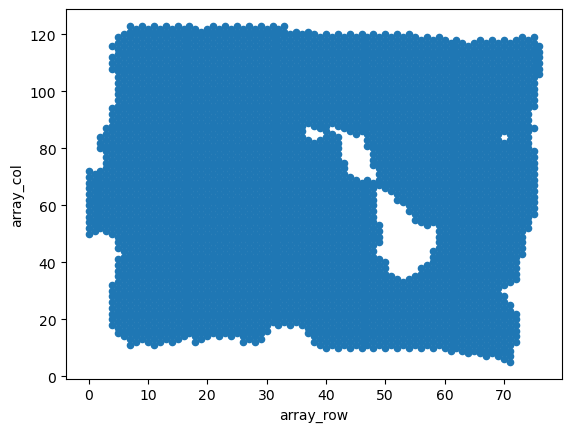

In [55]:
adata1.obs.plot.scatter(x='array_row', y='array_col')

<Axes: xlabel='array_row', ylabel='array_col'>

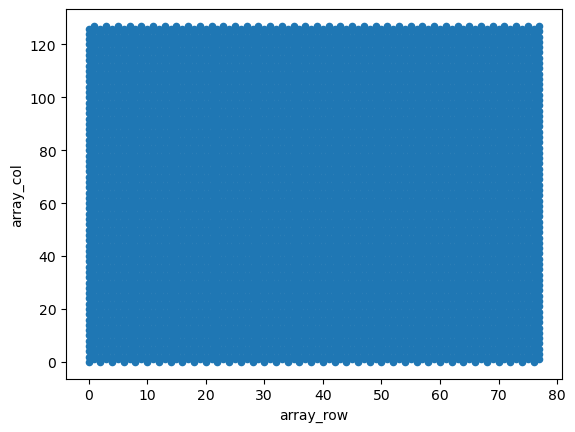

In [38]:
adata2.obs.plot.scatter(x='array_row', y='array_col')

In [39]:
adata1

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

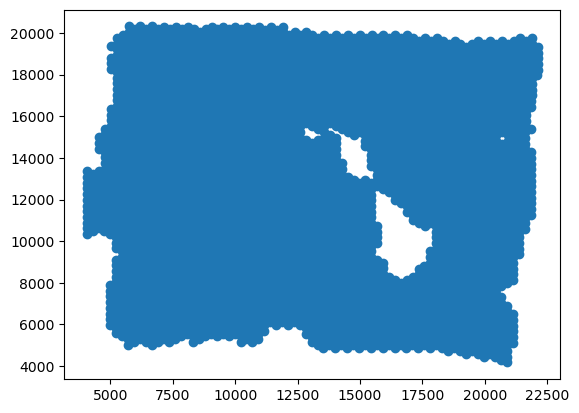

In [56]:
import matplotlib.pyplot as plt
p = adata1.obsm['spatial']
plt.scatter(p[:,1], p[:,0])

In [59]:
sp.im.ImageContainer.from_adata(adata1)

ImageContainer[shape=(2000, 2000), layers=['hires']]

In [57]:
p[:,1]

array([15937, 18054,  7383, ..., 18294, 14730,  5709])

In [58]:
p

array([[17428, 15937],
       [ 6092, 18054],
       [16351,  7383],
       ...,
       [ 7593, 18294],
       [ 7190, 14730],
       [10484,  5709]])

In [44]:
adata1.obs

,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACACCAATAACTGC-1,1,59,19
AAACAGAGCGACTCCT-1,1,14,94
AAACAGGGTCTATATT-1,1,47,13
AAACAGTGTTCCTGGG-1,1,73,43
...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77
TTGTTTCACATCCAGG-1,1,58,42
TTGTTTCATTAGTCTA-1,1,60,30
TTGTTTCCATACAACT-1,1,45,27


In [66]:
adata1.uns["spatial"]['V1_Breast_Cancer_Block_A_Section_1']["metadata"]["source_image_path"]

'/scratch/imb/uqjxie6/benchmmarking/DeepHis2Exp/data/Breast_Cancer_10x/block1/image.tif'

In [80]:
# adata1.uns["spatial"]

In [77]:
from PIL import Image

def read_tiff(path):
    Image.MAX_IMAGE_PIXELS = 933120000
    im = Image.open(path)
    imarray = np.array(im)
    # I = plt.imread(path)
    return im

o, oo = read_tiff(adata1.uns["spatial"]['V1_Breast_Cancer_Block_A_Section_1']["metadata"]["source_image_path"])

In [72]:
adata1.uns["spatial"]['V1_Breast_Cancer_Block_A_Section_1']["metadata"]["source_image_path"]

'/scratch/imb/uqjxie6/benchmmarking/DeepHis2Exp/data/Breast_Cancer_10x/block1/image.tif'

In [78]:
oo.shape

(24240, 24240, 3)

In [81]:
adata1

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [82]:
adata2

AnnData object with n_obs × n_vars = 4992 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
adata_dict = {'V1_Breast_Cancer_Block_A_Section_1': adata1,
             '1142243F': adata2}

In [87]:
ds.names

NameError: name 'ds' is not defined

In [92]:
adata_dict['V1_Breast_Cancer_Block_A_Section_1'].uns["spatial"]['V1_Breast_Cancer_Block_A_Section_1']["metadata"]["source_image_path"]

'/scratch/imb/uqjxie6/benchmmarking/DeepHis2Exp/data/Breast_Cancer_10x/block1/image.tif'

In [103]:
adata1.to_df()[list(['FAM138A', 'OR4F5', 'AL627309.1'])]

,FAM138A,OR4F5,AL627309.1
AAACAAGTATCTCCCA-1,0.0,0.0,0.0
AAACACCAATAACTGC-1,0.0,0.0,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0
AAACAGGGTCTATATT-1,0.0,0.0,0.0
AAACAGTGTTCCTGGG-1,0.0,0.0,0.0
...,...,...,...
TTGTTGTGTGTCAAGA-1,0.0,0.0,0.0
TTGTTTCACATCCAGG-1,0.0,0.0,0.0
TTGTTTCATTAGTCTA-1,0.0,0.0,0.0
TTGTTTCCATACAACT-1,0.0,0.0,0.0


In [106]:
adata1.obsm['spatial']

array([[17428, 15937],
       [ 6092, 18054],
       [16351,  7383],
       ...,
       [ 7593, 18294],
       [ 7190, 14730],
       [10484,  5709]])

In [108]:
np.floor(adata_dict['V1_Breast_Cancer_Block_A_Section_1'].obsm["spatial"])

array([[17428., 15937.],
       [ 6092., 18054.],
       [16351.,  7383.],
       ...,
       [ 7593., 18294.],
       [ 7190., 14730.],
       [10484.,  5709.]])

In [111]:
adata_dict['V1_Breast_Cancer_Block_A_Section_1'].obs[['array_row', 'array_col']].values

array([[ 50, 102],
       [ 59,  19],
       [ 14,  94],
       ...,
       [ 60,  30],
       [ 45,  27],
       [  7,  51]])

In [112]:
len(np.floor(adata_dict['V1_Breast_Cancer_Block_A_Section_1'].obsm["spatial"]))

3798

In [113]:
len(adata_dict['V1_Breast_Cancer_Block_A_Section_1'].obs[['array_row', 'array_col']].values)

3798

In [114]:
adata_dict['V1_Breast_Cancer_Block_A_Section_1'].obs

,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACACCAATAACTGC-1,1,59,19
AAACAGAGCGACTCCT-1,1,14,94
AAACAGGGTCTATATT-1,1,47,13
AAACAGTGTTCCTGGG-1,1,73,43
...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77
TTGTTTCACATCCAGG-1,1,58,42
TTGTTTCATTAGTCTA-1,1,60,30
TTGTTTCCATACAACT-1,1,45,27


In [116]:
adata_dict['V1_Breast_Cancer_Block_A_Section_1'].obsm['spatial']

array([[17428, 15937],
       [ 6092, 18054],
       [16351,  7383],
       ...,
       [ 7593, 18294],
       [ 7190, 14730],
       [10484,  5709]])

In [119]:
t = adata_dict['V1_Breast_Cancer_Block_A_Section_1'].obs[['array_row', 'array_col']].values

In [118]:
tt = adata_dict['V1_Breast_Cancer_Block_A_Section_1'].obsm['spatial']

In [120]:
t

array([[ 50, 102],
       [ 59,  19],
       [ 14,  94],
       ...,
       [ 60,  30],
       [ 45,  27],
       [  7,  51]])

In [121]:
t[:,1]

array([102,  19,  94, ...,  30,  27,  51])

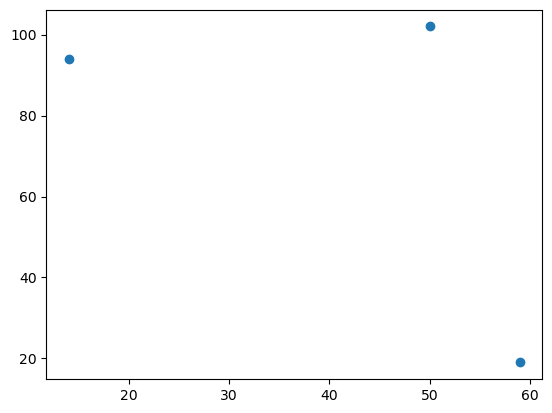

In [125]:
plt.scatter(t[:3,0], t[:3,1])

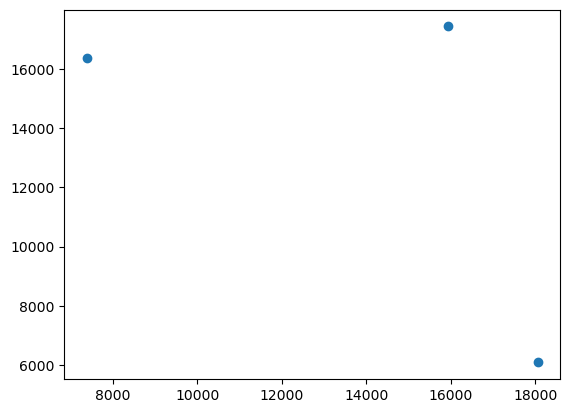

In [127]:
plt.scatter(tt[:3,1], tt[:3,0])

In [128]:
adata_dict['V1_Breast_Cancer_Block_A_Section_1'].obs[['array_row', 'array_col']]

,array_row,array_col
AAACAAGTATCTCCCA-1,50,102
AAACACCAATAACTGC-1,59,19
AAACAGAGCGACTCCT-1,14,94
AAACAGGGTCTATATT-1,47,13
AAACAGTGTTCCTGGG-1,73,43
...,...,...
TTGTTGTGTGTCAAGA-1,31,77
TTGTTTCACATCCAGG-1,58,42
TTGTTTCATTAGTCTA-1,60,30
TTGTTTCCATACAACT-1,45,27


In [130]:
adata_dict['V1_Breast_Cancer_Block_A_Section_1'].obs[['array_col', 'array_row']].values

array([[102,  50],
       [ 19,  59],
       [ 94,  14],
       ...,
       [ 30,  60],
       [ 27,  45],
       [ 51,   7]])

In [134]:
adata_dict['V1_Breast_Cancer_Block_A_Section_1'].n_obs

3798

In [135]:
len(adata_dict['V1_Breast_Cancer_Block_A_Section_1'].to_df())

3798

In [7]:
import sys
sys.path.append("../models/Hist2ST/")

import os
import glob
import torch
import torchvision
import numpy as np
import scanpy as sc
import pandas as pd 
import scprep as scp
import anndata as ad
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import ImageFile, Image
from utils import read_tiff, get_data
from graph_construction import calcADJ
from collections import defaultdict as dfd
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None


def read_tiff(path):
    Image.MAX_IMAGE_PIXELS = None
    im = Image.open(path)
    imarray = np.array(im)
    # I = plt.imread(path)
    return im


class ViT_Anndata(torch.utils.data.Dataset):
    """Some Information about ViT_SKIN"""
    def __init__(self, adata_dict, gene_list, train=True,r=4,norm=False,fold=0,flatten=True,ori=True,adj=True,prune='NA',neighs=4):
        super(ViT_Anndata, self).__init__()

        self.r = 224//r

        names = list(adata_dict.keys())

        self.ori = ori
        self.adj = adj
        self.norm = norm
        self.train = train
        self.flatten = flatten
        self.adata_dict = adata_dict
        self.gene_list = gene_list
        samples = names
        te_names = [samples[fold]]
        tr_names = list(set(samples)-set(te_names))

        if train:
            self.names = tr_names
        else:
            self.names = te_names

        print(te_names)
        print('Loading imgs...')
        self.img_dict = {i:torch.Tensor(np.array(self.get_img(i))) for i in self.names}

        self.gene_set = list(gene_list)
        if self.norm:
            self.exp_dict = {
                i:sc.pp.scale(scp.transform.log(scp.normalize.library_size_normalize(m.to_df()[self.gene_set].values)))
                for i,m in self.adata_dict.items()
            }
        else:
            self.exp_dict = {
                i:scp.transform.log(scp.normalize.library_size_normalize(m.to_df()[self.gene_set].values)) 
                for i,m in self.adata_dict.items()
            }
        if self.ori:
            self.ori_dict = {i:m.to_df()[self.gene_set].values for i,m in self.adata_dict.items()}
            self.counts_dict={}
            for i,m in self.ori_dict.items():
                n_counts=m.sum(1)
                sf = n_counts / np.median(n_counts)
                self.counts_dict[i]=sf
        self.center_dict = {
            i:np.floor(m.obsm["spatial"]).astype(int)
            for i,m in self.adata_dict.items()
        }
        self.loc_dict = {i:m.obs[['array_col', 'array_row']].values for i,m in self.adata_dict.items()}
        self.adj_dict = {
            i:calcADJ(m,neighs,pruneTag=prune)
            for i,m in self.loc_dict.items()
        }
        self.patch_dict=dfd(lambda :None)
        self.lengths = [i.n_obs for i in self.adata_dict.values()]
        self.cumlen = np.cumsum(self.lengths)
        self.id2name = dict(enumerate(self.names))


    def filter_helper(self):
        a = np.zeros(len(self.gene_list))
        n = 0
        for i,exp in self.exp_dict.items():
            n += exp.shape[0]
            exp[exp>0] = 1
            for j in range((len(self.gene_list))):
                a[j] += np.sum(exp[:,j])


    def __getitem__(self, index):
        ID=self.id2name[index]
        im = self.img_dict[ID].permute(1,0,2)

        exps = self.exp_dict[ID]
        if self.ori:
            oris = self.ori_dict[ID]
            sfs = self.counts_dict[ID]
        adj=self.adj_dict[ID]
        centers = self.center_dict[ID]
        loc = self.loc_dict[ID]
        patches = self.patch_dict[ID]
        positions = torch.LongTensor(loc)
        patch_dim = 3 * self.r * self.r * 4
        exps = torch.Tensor(exps)
        if patches is None:
            n_patches = len(centers)
            if self.flatten:
                patches = torch.zeros((n_patches,patch_dim))
            else:
                patches = torch.zeros((n_patches,3,2*self.r,2*self.r))

            for i in range(n_patches):
                center = centers[i]
                x, y = center
                patch = im[(x-self.r):(x+self.r),(y-self.r):(y+self.r),:]
                if self.flatten:
                    patches[i] = patch.flatten()
                else:
                    patches[i]=patch.permute(2,0,1)
            self.patch_dict[ID]=patches
        data=[patches, positions, exps]
        if self.adj:
            data.append(adj)
        if self.ori:
            data+=[torch.Tensor(oris),torch.Tensor(sfs)]
        data.append(torch.Tensor(centers))
        return data
        
    def __len__(self):
        return len(self.exp_dict)

    def get_img(self,name):
        path = self.adata_dict[name].uns["spatial"][name]["metadata"]["source_image_path"]
        im = read_tiff(path)
        return im

In [8]:
gene_list = ["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", 
           "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]
ds = ViT_Anndata(adata_dict = adata_dict, gene_list = gene_list,
            train='train',fold=0,flatten=False,adj=True,ori=True,prune='NA'
        )

['V1_Breast_Cancer_Block_A_Section_1']
Loading imgs...


In [9]:
ds.names

['1142243F']

In [10]:
from torch.utils.data import DataLoader
train_loader = DataLoader(ds, batch_size=1, num_workers=0, shuffle=True)


In [11]:
iterator=iter(train_loader)
test = next(iterator)

In [13]:
next(iterator)
print(ds.patch_dict.keys())
next(iterator)
print(ds.patch_dict.keys())
next(iterator)
print(ds.patch_dict.keys())


KeyError: 1

In [14]:
ds.id2name

{0: '1142243F'}